<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/12_gan/06_BigGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BigGAN
## 目的
高解像度な画像生成ができるBigGANを動かすことによって，最先端のGANの凄さを実感する．

## 必要となるモジュールのインポート

In [ ]:
import os 
import sys
import shutil
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader
from torchvision import transforms

# ネットワークの構築
BigGANは，膨大なマシンリソースをフル活用して高解像度化に成功した，cGANの一種として知られています．
BigGANは，Miyatoらが提案したSpectral Normalization GAN (SN-GAN)とZhangらが提案したSelf-Attention GAN (SA-GAN)をベースにネットワークを構成しています．

そこで，まずSpectral Normalizationと呼ばれるテクニックの構築をします．
Spectral Normalization (SN)は，ネットワーク内のリプシッツ連続を保証するために必要な正規化です．
GANの学習安定化及び高解像度化に最適化されたテクニックと捉えることもできます．

GANの学習は，単純に2つのネットワークの誤差が競合するように設計されており，プログラム上ではbianry corss entropyなどで実装できる反面で，非常に不安定であることが広く知られています．
そのため，SNが提案される以前は，Wasserstein距離をGANの誤差として学習するWasserstein GAN (WGAN)や，WGANをさらに応用したWGAN Gradient Penallty (WGAN-GP)などが頻繁に使用されていました．
WGANでは，Discriminatorの重みを一定の範囲に収まるように無理矢理クリップしている（リプシッツ連続を保証するため）ため，非常に強い制約がネットワーク全体に科されていました．
この強い制約を打破した手法がWGAN-GPです．
WGAN-GPでは，Discriminatorの出力値の勾配のl1ノルムを誤差関数に含めて学習することによってWGANと同様のモチベーションを実現しました．
しかし，WGAN-GPでもまだ制約は強く，2回微分を求めることが必要なため，計算コストが嵩んでしまいます．

これらを踏まえてMiyatoらは，何かしらの方法によってDiscriminator内部のリプシッツ連続を保証すれば十分であることを発見して，SNが提案されました．
SNは，Discriminator内の全ての層に適用することで効果を発揮します．

### Spectral Normalizationの構築

In [ ]:
def proj(x, y):
    return torch.mm(y, x.t()) * y / torch.mm(y, y.t())

def gram_schmidt(x, ys):
    for y in ys:
        x = x - proj(x, y)
    return x

def power_iteration(W, u_, update=True, eps=1e-12):
    us, vs, svs = [], [], []
    for i, u in enumerate(u_):
        with torch.no_grad():
            v = torch.matmul(u, W)
            v = F.normalize(gram_schmidt(v, vs), eps=eps)
            vs += [v]
            u = torch.matmul(v, W.t())
            u = F.normalize(gram_schmidt(u, us), eps=eps)
            us += [u]
            if update:
                u_[i][:] = u
        svs += [torch.squeeze(torch.matmul(torch.matmul(v, W.t()), u.t()))]
    return svs, us, vs

class SpectralNorm(object):
    def __init__(self, num_svs, num_itrs, num_outputs, transpose=False, eps=1e-12):
        self.num_itrs = num_itrs
        self.num_svs = num_svs
        self.transpose = transpose
        self.eps = eps
        for i in range(self.num_svs):
            self.register_buffer('u%d' % i, torch.randn(1, num_outputs))
            self.register_buffer('sv%d' % i, torch.ones(1))
  
    @property
    def u(self):
        return [getattr(self, 'u%d' % i) for i in range(self.num_svs)]

    @property
    def sv(self):
        return [getattr(self, 'sv%d' % i) for i in range(self.num_svs)]
   
    def W_(self):
        W_mat = self.weight.view(self.weight.size(0), -1)
        if self.transpose:
            W_mat = W_mat.t()
        for _ in range(self.num_itrs):
            svs, us, vs = power_iteration(W_mat, self.u, update=self.training, eps=self.eps) 
        if self.training:
            with torch.no_grad():
                for i, sv in enumerate(svs):
                    self.sv[i][:] = sv     
        return self.weight / svs[0]

### Self Attention layerの構築
SA-GANは，名前の通りSelf Attentionを取り入れたGANです．
GANに初めてAttentionという考えを導入した最も初めの手法です．

一般的にGANの学習において，CIFAR-10やCIFAR-10などの自然画像のようにデータ全体を通して姿勢が一定でない（様々な姿勢を取りうる）データの生成は崩れた画像になることが知られています．
Generator及びDiscriminatorで，特徴マップのサイズがなるべく大きい時にSelf attentionを施すことによって先に述べた問題を解決します．

Self Attentionの作成方法は，とても単純で特徴マップに3種類の畳み込みを施してkey，value，queryとなる特徴マップを作成ます．
3つの特徴マップを，self attentionの計算方法に則りattention mapを作成しています．

<img src="https://www.dropbox.com/s/0s4eo5p84r01yt6/self-attention.png?dl=1" width=80%>

In [ ]:
class Self_Attention(nn.Module):
    def __init__(self, in_dim, act):
        super(Self_Attention, self).__init__()
        self.channel_in = in_dim
        self.act = act
        
        self.query_conv = SpectralNormConv2d(in_dim, in_dim//8, kernel_size=1)
        self.key_conv = SpectralNormConv2d(in_dim, in_dim//8, kernel_size=1)
        self.value_conv = SpectralNormConv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = Parameter(torch.zeros(1))
        
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        b, c, w, h = x.size()
        ## (B, Ch, W, H) --> (B, Ch, WxH) --> (B, WxH, Ch)
        query = self.query_conv(x).view(b, -1, w*h).permute(0, 2, 1)
        ## (B, Ch, W, H) --> (B, Ch, WxH)
        key = self.key_conv(x).view(b, -1, w*h)
        ## query @ key
        energy = torch.bmm(query, key)
        attn = self.softmax(energy)
        ## (B, Ch, W, H) --> (B, Ch, WxH)
        value = self.value_conv(x).view(b, -1, w*h)
        
        ## value @ attn:(B, WxH, Ch)
        out = torch.bmm(value, attn.permute(0, 2, 1))
        out = out.view(b, c, w, h)
        out = self.gamma*out + x
        return out

### Conditional Batch Normalizationの構築
BigGANは，入力した潜在変数と条件からGenerator内の全層のBatch Normalizationのアフィンパラメータを生成します．
Pytorchなどで実装されているBatch Normalizationに少し手を加えるだけで実現できます．

In [ ]:
class ConditionalBatchNorm(nn.Module):
    def __init__(self, in_channel, n_condition=148):
        super(ConditionalBatchNorm, self).__init__()

        self.bn = nn.BatchNorm2d(in_channel, affine=False)

        self.embed = nn.Linear(n_condition, in_channel* 2)
        self.embed.weight.data[:, :in_channel] = 1
        self.embed.weight.data[:, in_channel:] = 0

    def forward(self, input, class_id):
        out = self.bn(input)
        embed = self.embed(class_id)
        gamma, beta = embed.chunk(2, 1)
        gamma = gamma.unsqueeze(2).unsqueeze(3)
        beta = beta.unsqueeze(2).unsqueeze(3)
        return gamma * out + beta

### Cross Replica Batch Normalizationの構築
Generatorの最後のBatch Normalizationは，Conditional Batch Normalizationではなく異なるものが使用されています．
それがCross Replica Batch Normalizationというものです．

In [ ]:
class _BatchNorm(nn.Module):
    _version = 2

    def __init__(self, num_features, eps=1e-4, momentum=0.1, affine=True,
                 track_running_stats=True):
        super(_BatchNorm, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        if self.affine:
            self.weight = Parameter(torch.Tensor(num_features))
            self.bias = Parameter(torch.Tensor(num_features))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
            self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)
            self.register_parameter('num_batches_tracked', None)
        self.reset_parameters()

    def reset_running_stats(self):
        if self.track_running_stats:
            self.running_mean.zero_()
            self.running_var.fill_(1)
            self.num_batches_tracked.zero_()

    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            self.weight.data.uniform_()
            self.bias.data.zero_()

    def _check_input_dim(self, input):
        raise NotImplementedError

    def forward(self, input):
        self._check_input_dim(input)

        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            self.num_batches_tracked += 1
            if self.momentum is None:  # use cumulative moving average
                exponential_average_factor = 1.0 / self.num_batches_tracked.item()
            else:  # use exponential moving average
                exponential_average_factor = self.momentum

        return F.batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            self.training or not self.track_running_stats,
            exponential_average_factor, self.eps)

    def extra_repr(self):
        return '{num_features}, eps={eps}, momentum={momentum}, affine={affine}, ' \
               'track_running_stats={track_running_stats}'.format(**self.__dict__)

    def _load_from_state_dict(self, state_dict, prefix, metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        version = metadata.get('version', None)

        if (version is None or version < 2) and self.track_running_stats:
            # at version 2: added num_batches_tracked buffer
            #               this should have a default value of 0
            num_batches_tracked_key = prefix + 'num_batches_tracked'
            if num_batches_tracked_key not in state_dict:
                state_dict[num_batches_tracked_key] = torch.tensor(0, dtype=torch.long)

        super(_BatchNorm, self)._load_from_state_dict(
            state_dict, prefix, metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

class ScaledCrossReplicaBatchNorm2d(_BatchNorm):
    def _check_input_dim(self, input):
        if input.dim() != 4:
            raise ValueError('expected 4D input (got {}D input)'
                             .format(input.dim()))

### ネットワーク構築に必要なモジュールの改造

In [ ]:
class SpectralNormConv2d(nn.Conv2d, SpectralNorm):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
             padding=0, dilation=1, groups=1, bias=True, 
             num_svs=1, num_itrs=1, eps=1e-12):
        nn.Conv2d.__init__(self, in_channels, out_channels, kernel_size, stride, 
                     padding, dilation, groups, bias)
        SpectralNorm.__init__(self, num_svs, num_itrs, out_channels, eps=eps)    
    
    def forward(self, x):
        return F.conv2d(x, self.W_(), self.bias, self.stride, 
                        self.padding, self.dilation, self.groups)
    
class SpectralNormLinear(nn.Linear, SpectralNorm):
    def __init__(self, in_features, out_features, bias=True,
                 num_svs=1, num_itrs=1, eps=1e-12):
        nn.Linear.__init__(self, in_features, out_features, bias)
        SpectralNorm.__init__(self, num_svs, num_itrs, out_features, eps=eps)
    
    def forward(self, x):
        return F.linear(x, self.W_(), self.bias)
    
class SpectralNormEmbedding(nn.Embedding, SpectralNorm):
    def __init__(self, num_embeddings, embedding_dim, padding_idx=None, 
                 max_norm=None, norm_type=2, scale_grad_by_freq=False,
                 sparse=False, _weight=None,
                 num_svs=1, num_itrs=1, eps=1e-12):
        nn.Embedding.__init__(self, num_embeddings, embedding_dim, padding_idx,
                              max_norm, norm_type, scale_grad_by_freq, 
                              sparse, _weight)
        SpectralNorm.__init__(self, num_svs, num_itrs, num_embeddings, eps=eps)
  
    def forward(self, x):
        return F.embedding(x, self.W_())

### Generatorの構築
BigGANは，Residual Networkをベースにネットワークが構築されています．
先ほどまでに定義したレイヤやモジュールを用いてネットワークの構築をします．

また，SN-GANやSA-GANでは，SNをDiscriminatorのみ使用してGeneratorは通常と同じように構築されています．
しかしながら，BigGANではSNをGeneratorに対しても使用してリプシッツ連続を満たすようにすることで，学習が安定化して高解像度な画像の生成が可能となっています．

<img src="https://www.dropbox.com/s/gmw05zwla6hoeoo/BigGAN_G.png?dl=1" width=70%>

図中のSplitは，潜在変数を任意の次元で分割する処理を表しています．Concatは，分割した潜在変数及びクラスラベルを結合する処理を表しています．図中には，単純にConv.と記載しましたが，実際にはSpectral normalizationを施したConvolutionであることに注意してください．

In [ ]:
class GResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, 
                 padding=1, n_cls=None, bn=True, act='relu', up=True):
        super(GResBlock, self).__init__()
        self.upsample = up
        self.bn = bn
        
        self.c1 = SpectralNormConv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.c2 = SpectralNormConv2d(out_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.c1x1 = SpectralNormConv2d(in_channel, out_channel, kernel_size=1, stride=1, padding=0, bias=True)
        
        self.upsample_layer = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.cbn1 = ConditionalBatchNorm(in_channel, 128+20)
        self.cbn2 = ConditionalBatchNorm(out_channel, 128+20)
        
        if act == 'relu':
            self.activation = nn.ReLU()
        elif act == 'lrelu':
            self.activation = nn.LeakyReLU()
        elif act == 'tanh':
            self.activation = nn.Tanh()
        else:
            assert 0, '%s is not supported.' % act
            
    def forward(self, x, y):
        x1 = self.c1x1(self.upsample_layer(x))
        
        h1 = self.cbn1(x, y)
        h1 = self.activation(h1)
        h1 = self.upsample_layer(h1)
        h1 = self.c1(h1)
        
        h2 = self.cbn2(h1, y)
        h2 = self.activation(h2)
        h2 = self.c2(h2)
        
        return x1 + h2

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_latent=120, n_ch=64, n_cls=100, n_block=6):
        super(Generator, self).__init__()
        self.n_ch = n_ch
        self.linear_latent = SpectralNormLinear(20, 4*4*16*n_ch)
        self.linear_condition = SpectralNormLinear(n_cls, 128)
            
        self.blocks = nn.ModuleList([
            GResBlock(16*n_ch, 16*n_ch, n_cls=n_cls),
            GResBlock(16*n_ch, 8*n_ch, n_cls=n_cls),
            GResBlock(8*n_ch, 4*n_ch, n_cls=n_cls),
            GResBlock(4*n_ch, 2*n_ch, n_cls=n_cls),
            Self_Attention(2*n_ch, nn.Softmax()),
            GResBlock(2*n_ch, 1*n_ch, n_cls=n_cls),
        ])
        
        self.bn = ScaledCrossReplicaBatchNorm2d(1*n_ch)
        self.relu = nn.ReLU()
        self.conv = SpectralNormConv2d(1*n_ch, 3, kernel_size=3, stride=1, padding=1, bias=False)
        self.tanh = nn.Tanh()
        
        self.init_weights()
        
    def init_weights(self):
        self.param_count = 0
        for module in self.modules():
            if (isinstance(module, nn.Conv2d) 
             or isinstance(module, nn.Linear) 
             or isinstance(module, nn.Embedding)):
                init.orthogonal_(module.weight)
                self.param_count += sum([p.data.nelement() for p in module.parameters()])
        print('Param count for G''s initialized parameters: %d' % self.param_count)
        
    def forward(self, z, y):
        split_latent = torch.split(z, split_size_or_sections=20, dim=1)
        proj_cond = self.linear_condition(y)
        
        z_idx = 0
        out = self.linear_latent(split_latent[z_idx])
        out = out.view(-1, 16*self.n_ch, 4, 4)
        for idx, block in enumerate(self.blocks):
            if idx == len(self.blocks) - 2:
                out = block(out)
            else:
                z_idx += 1
                cond = torch.cat((split_latent[z_idx], proj_cond), dim=1)
                out = block(out, cond)
        
        out = self.bn(out)
        out = self.relu(out)
        out = self.conv(out)
        out = self.tanh(out)
        return out

### Discriminatorの構築
Discriminatorは，SN-GANやSA-GANと同じように構築します．
また，cGANと同じようにDiscriminatorの入力層に直接条件を与えるのではなく，Miyatoらが提案したprojection discriminatorのアイデアを用いてネットワークへ条件を提供します．

projection discriminatorは，条件を任意の次元のベクトル（discriminatorの出力値と同じ次元数）へ投影し，discriminatorの出力値に足し合わせるだけの簡単な与え方です．
このように与えることによって，条件を考慮した画像生成の促進をすることが可能です．

<img src="https://www.dropbox.com/s/dmy1ve51gup60u8/BigGAN_D.png?dl=1" width=50%>

In [ ]:
class DResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=1, act='relu', down=True):
        super(DResBlock, self).__init__()
        self.c1x1 = SpectralNormConv2d(in_channel, out_channel, kernel_size=1, stride=1, padding=0, bias=True)
        self.c1 = SpectralNormConv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
        self.c2 = SpectralNormConv2d(out_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
        
        if act == 'relu':
            self.activation = nn.ReLU()
        elif act == 'lrelu':
            self.activation = nn.LeakyReLU()
        elif act == 'tanh':
            self.activation = nn.Tanh()
        else:
            assert 0, '%s is not supported.' % act
            
        self.down = down
        if down:
            self.avg = nn.AvgPool2d(2, 2)
        
    def forward(self, x):
        if self.down:
            x1 = self.avg(self.c1x1(x))
        else:
            x1 = self.c1x1(x)
        
        h = self.c1(self.activation(x))
        h = self.c2(self.activation(h))
        
        if self.down:
            h = self.avg(h)
        
        return x1 + h

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_ch=64, n_cls=100):
        super(Discriminator, self).__init__()
        
        self.first_layer = nn.Sequential(
            SpectralNormConv2d(3, 1*n_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            SpectralNormConv2d(1*n_ch, 1*n_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.AvgPool2d(2, 2))
        
        self.first_skip = SpectralNormConv2d(3, 1*n_ch, kernel_size=1, stride=1, padding=0, bias=True)
        self.avgpool = nn.AvgPool2d(2, 2)
        
        self.blocks = nn.Sequential(
            DResBlock(1*n_ch, 2*n_ch, down=True),
            Self_Attention(2*n_ch, nn.Softmax()),
            DResBlock(2*n_ch, 4*n_ch, down=True),
            DResBlock(4*n_ch, 8*n_ch, down=True),
            DResBlock(8*n_ch, 16*n_ch, down=True),
            DResBlock(16*n_ch, 16*n_ch, down=True),
            DResBlock(16*n_ch, 16*n_ch, down=False))
        self.relu = nn.ReLU()
        
        self.linear = SpectralNormLinear(16*n_ch, 1)
        self.emb_cls = SpectralNormEmbedding(n_cls, 16*n_ch)
        #self.embed_cls.weight.data.uniform_(-0.1, 0.1)
        #self.emb_cls = spectral_norm(self.embed_cls)
        
        self.init_weights()
        
    def init_weights(self):
        self.param_count = 0
        for module in self.modules():
            if (isinstance(module, nn.Conv2d) 
             or isinstance(module, nn.Linear) 
             or isinstance(module, nn.Embedding)):
                init.orthogonal_(module.weight)
                self.param_count += sum([p.data.nelement() for p in module.parameters()])
        print('Param count for D''s initialized parameters: %d' % self.param_count)
        
    def forward(self, x, y):
        out = self.first_layer(x)
        out_skip = self.avgpool(self.first_skip(x))
        out = out + out_skip
        
        for idx, block in enumerate(self.blocks):
            out = block(out)
        out = self.relu(out)
        out = out.view(out.size(0), out.size(1), -1)
        out = out.sum(dim=2)
        
        out_linear = self.linear(out).squeeze(1)
        embed = self.emb_cls(y)
        proj = (out * embed).sum(1)
        
        return out_linear + proj

### BigGANの学習
本来であれば，構築したネットワークを任意のデータセットで学習するのですが，Colabolatoryでは，学習が終わらないので事前に学習したネットワークの重みを用いて画像を生成します．

今回ダウンロードするモデルは，LSUNというデータセットの中から10クラスのみ用いて学習したものです．
画像サイズは128×128です．
以下のリンクからpretrainモデルのzipファイルをダウンロードし，解凍をします．
中にはGeneratorのパラメータ**gen**と，Discriminatorのパラメータ**dis**が入っています．

In [ ]:
!wget -q https://www.dropbox.com/s/xanox9atls6kuxa/BigGAN_pretrained_models.zip -O BigGAN_pretrained_models.zip
!unzip -q -o BigGAN_pretrained_models.zip

### パラメータの定義

In [ ]:
modelpath = './BigGAN_pretrained_models/gen'
categories = ['airplane', 'bird', 'bottle', 'bus', 'car', 
              'cat', 'dog', 'horse', 'motorbike', 'sheep']
cls_idx = None
resample_module = False
threshold = 1
n_latent = 120
n_ch = 64
n_cls = len(categories)
n_block = 6
n_img = 100
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

G = Generator(n_latent, n_ch, n_cls, n_block).to(device)
D = Discriminator(n_channel=64, n_cls
G.load_state_dict(torch.load(modelpath))

Param count for Gs initialized parameters: 31857952


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### BigGANを学習するためのソースコード
BigGANは，あまりにもネットワークが精密に作ってあるためColablatry上では到底，学習が終わりません．一応ソースコードを載せておくので，学習リソースを用意できる人は自分のPCへダウンロードして，好きなデータセットを用いて学習してください．

In [ ]:
def ortho(model, strength=1e-4, blacklist=[]):
    with torch.no_grad():
        for param in model.parameters():
            # Only apply this to parameters with at least 2 axes, and not in the blacklist
            if len(param.shape) < 2 or any([param is item for item in blacklist]):
                continue
            w = param.view(param.shape[0], -1)
            grad = (2 * torch.mm(torch.mm(w, w.t()) 
                    * (1. - torch.eye(w.shape[0], device=w.device)), w))
            param.grad.data += strength * grad.view(param.shape)

BigGANを学習する際の誤差関数は，hinge lossかwgan-gpの誤差関数を利用します．hinge lossの方が安定した学習で高解像な画像が生成される傾向にあるので，そちらを使用することをお勧めします．

In [ ]:
epochs = 100
beta1 = 0
beta2 = 0.999
lr_G, lr_D = 5e-5, 2e-4
G_ortho, D_ortho = 1e-4, 0.0
lambda_gp = 10
loss_func = 'hinge'
G_opt = optim.Adam(G.parameters(), lr=lr_G, betas=(beta1, beta2))
D_opt = optim.Adam(D.parameters(), lr=lr_D, betas=(beta1, beta2))

iteration = 0
for epoch in range(1, epochs):
    print('Training networks for a epoch.')
    for idx, (img, tgt) in enumerate(training_dataset):
        G.train()
        D.train()
        real_img = img.cuda()
        onehot = torch.eye(conf.n_cls)[tgt].type_as(real_img)
        
        # ====================== Update Discriminator ======================
        D.zero_grad()
        dis_real_out = D(real_img, tgt.cuda())
        if loss_func == 'wgan-gp':
            dis_real = -torch.mean(dis_real_out)
        elif loss_func == 'hinge'
            dis_real = nn.ReLU()(1.0 - dis_real_out).mean()
        
        z = torch.randn(conf.batch_size, conf.n_latent).cuda()
        fake_img = G(z, onehot)
        dis_fake_out = D(fake_img, tgt.cuda())
        if loss_func == 'wgan-gp':
            dis_fake = torch.mean(dis_fake_out)
        elif loss_func == 'hinge':
            dis_fake = nn.ReLU()(1.0 + dis_fake_out).mean()
        dis_loss = dis_real + dis_fake
        dis_loss.backward()
        
        if D_ortho > 0.0:
            ortho(D, D_ortho)
            
        D_opt.step()
        
        if loss_func == 'wgan-gp':
            eps = torch.rand(real_img.size(0), 1, 1, 1).cuda().expand_as(real_img)
            interpolated = torch.autograd.Variable(eps * real_img.data + (1 - eps) * fake_img.data, 
                                                   requires_grad=True)
            out = D(interpolated, tgt.cuda())

            grad = torch.autograd.grad(outputs=out,
                                       inputs=interpolated,
                                       grad_outputs=torch.ones(out.size()).cuda(),
                                       retain_graph=True,
                                       create_graph=True,
                                       only_inputs=True)[0]

            grad = grad.view(grad.size(0), -1)
            grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
            d_loss_gp = torch.mean((grad_l2norm - 1) ** 2)

            d_loss = lambda_gp * d_loss_gp
        
        # ====================== Update Generator ======================
        G.zero_grad()
        z = torch.randn(conf.batch_size, conf.n_latent).cuda()
        fake_img = G(z, onehot)
        gen_out = D(fake_img, tgt.cuda())
        gen_loss = - gen_out.mean()
        gen_loss.backward()
        
        if G_ortho > 0.0:
            ortho(G, G_ortho, blacklist=[param for param in G.shared.parameters()])
            
        G_opt.step()
        
        iteration += 1
        if idx %  100 == 0:
            print('Training epoch: {} [{}/{} ({:.0f}%)] | D loss : {:.6f} | G loss: {:.6f} |'\
                  .format(epoch, idx * len(img), len(training_dataset.dataset),
                  100. * idx / len(training_dataset), dis_loss.item(), gen_loss.item()))
            tb.add_scalars('prediction loss',
                           {'D': dis_loss.item(),
                            'G': gen_loss.item()},
                            iteration)

### 画像の生成
実際に画像を生成してみましょう．

生成するクラスは，任意に設定することができます．
特に何も指定をしなければランダムに決定したクラスを生成することになります．
自分の好きなクラスを生成したいときは，**cls_idx**を適当なintの数字にしてください．

In [ ]:
def resampling_module(org_noise, n_batch=30, n_latent=120, th=2):
    resample_noise = torch.empty(n_batch, n_latent)
    for d1_idx, z in enumerate(org_noise):
        for d2_idx, v in enumerate(z):
            while True:
                if v > - th and v < th:break
                v = torch.rand(1)
            resample_noise[d1_idx, d2_idx] = v

    return resample_noise

Generated class: motorbike


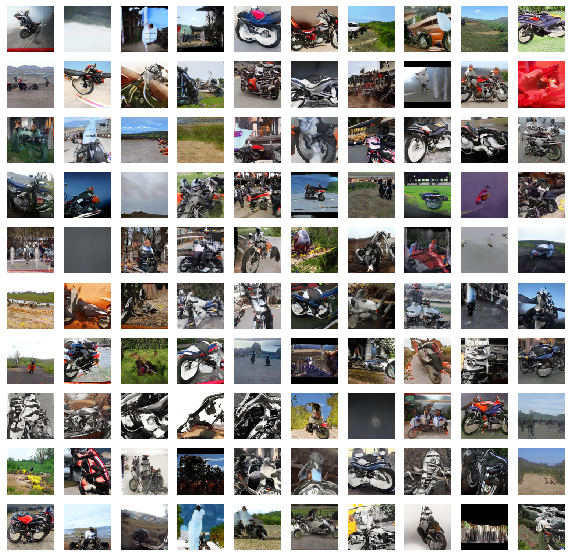

In [ ]:
if cls_idx:
    cls_idx = cls_idx
else:
    cls_idx = np.random.randint(n_cls)
    
latent = torch.randn(n_img, n_latent).to(device)
onehot = torch.eye(n_cls)[cls_idx].unsqueeze(0).expand(n_img, n_cls).to(device)
if resample_module:
    latent = resampling_module(latent, n_batch=n_img, n_latent=n_latent, th=threhould).to(device)
else:
    latent = latent

G.eval()
with torch.no_grad():
    imgs = G(latent, onehot)

print('Generated class: %s' % categories[cls_idx])

row = 10
col = 10
plt.figure(figsize=(10,10))

num = 0
while num < row * col:
    img = (imgs[num] * 256.).permute(1,2,0).clamp(min=0., max=255.).data.cpu().numpy().astype(np.uint8)
    num += 1
    plt.subplot(row, col, num)
    plt.imshow(img)
    plt.axis('off')

## 課題
1. resampling_moduleの閾値(th)を変更したらどのようになっていくか確認してみましょう．
2. 任意の2つの潜在変数の間を線形補間した場合に，どのような画像が生成されるか確認してみましょう．